# Twitter Classification Project

In this project, I am going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before going into using the classifier, let's first consider the problem I'm trying to solve. Which features of a tweet are most closely linked to its popularity? Probably the length of the tweet strongly influences its popularity. Probably its virality is dependent on how many followers the person has. 

Let's explore these options by looking at the data available:

* The total number of tweets in the dataset.
* The columns, or features, of the dataset.
* The text of the first tweet in the dataset.


In [2]:
import pandas as pd 

all_tweets = pd.read_json("random_tweets.json", lines=True)

The total number of tweets in the dataset:

In [3]:
len(all_tweets)

11099

The features of the dataset:

In [4]:
all_tweets.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')

The text of the first tweet in the dataset:

In [5]:
all_tweets.loc[0]["text"]

'RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…'

Note: some of these features are dictionaries. For example, the feature `user` is a dictionary. Let's see what the `user` feature looks like.

In [6]:
all_tweets.loc[0]["user"]

{'id': 145388018,
 'id_str': '145388018',
 'name': 'Derek Wolkenhauer',
 'screen_name': 'derekw221',
 'location': 'Waterloo, Iowa',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 215,
 'friends_count': 335,
 'listed_count': 2,
 'created_at': 'Tue May 18 21:30:10 +0000 2010',
 'favourites_count': 3419,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': False,
 'statuses_count': 4475,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '022330',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/995790590276243456/cgxRVviN_normal.jpg',
 'profile_image_url_https': 'https://pbs.twimg.com/profile

Let's try printing just the `location` found in that `user` dictionary.

In [7]:
all_tweets.loc[0]["user"]["location"]

'Waterloo, Iowa'

### Defining Viral Tweets

Since I will use a K-Nearest Neighbor classifier, which is a supervised machine learning algorithm, I need to have a dataset with tagged labels. For this situation, I need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of our dataset. Thus, I will create this feature.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has.

I will create a new column, `is_viral`, that is a "1" if the tweet had more than 10 retweets and "0" otherwise.

In [9]:
import numpy as np

all_tweets["is_viral"] = np.where(all_tweets["retweet_count"] > 10, 1, 0)

all_tweets["is_viral"]

0        0
1        0
2        0
3        1
4        0
        ..
11094    1
11095    1
11096    0
11097    0
11098    0
Name: is_viral, Length: 11099, dtype: int32

However, instead of using 10 as the benchmark for a viral tweet, it would be better to use the median number of retweets. 

In [10]:
median_retweets = all_tweets["retweet_count"].median()

median_retweets

13.0

In [11]:
all_tweets["is_viral"] = np.where(all_tweets["retweet_count"] >= median_retweets, 1, 0)

all_tweets["is_viral"]

0        0
1        0
2        0
3        1
4        0
        ..
11094    1
11095    1
11096    0
11097    0
11098    0
Name: is_viral, Length: 11099, dtype: int32

Let's see how many viral tweets we have:

In [12]:
all_tweets['is_viral'].value_counts()

1    5591
0    5508
Name: is_viral, dtype: int64

### Making Features

Which features might determine whether a tweet is viral? 

I believe the length of the tweet might be a valuable feature. Let's create a new column, `tweet_lenght`:

In [13]:
all_tweets["tweet_length"] = all_tweets.apply(lambda x: len(x["text"]), axis=1)

all_tweets["tweet_length"]

0        140
1         77
2        140
3        140
4        140
        ... 
11094    140
11095     75
11096    140
11097    140
11098     75
Name: tweet_length, Length: 11099, dtype: int64

Also, the number of followers might be an important feature:

In [14]:
all_tweets["followers_count"] = all_tweets.apply(lambda x: x["user"]["followers_count"], axis=1)

all_tweets["followers_count"]

0         215
1         199
2         196
3        3313
4         125
         ... 
11094     509
11095     462
11096     135
11097      59
11098    1563
Name: followers_count, Length: 11099, dtype: int64

Additionally, the number of friends would be important:

In [15]:
all_tweets["friends_count"] = all_tweets.apply(lambda x: x["user"]["friends_count"], axis=1)

all_tweets["friends_count"]

0         335
1         203
2         558
3        2272
4         273
         ... 
11094    1323
11095    1033
11096      90
11097     320
11098    1697
Name: friends_count, Length: 11099, dtype: int64

For now, I will be using these three features, but I might have to consider some of the following potential features:

* The number of hashtags in the tweet.
* The number of links in the tweet.
* The number of words in the tweet. 
* The average length of the words in the tweet.

### Normalizing Data

Create `labels`:

In [16]:
labels = all_tweets["is_viral"]

Create `data`, which includes the features `tweet_length`, `followers_count`, and `friends_count`:

In [17]:
data = all_tweets[["tweet_length", "followers_count", "friends_count"]]

Create `scaled_data` to normalize the data so all of the features will vary within the same range:

In [18]:
from sklearn.preprocessing import scale

scaled_data = scale(data, axis=0) # 0 to scale the columns as opposed to the rows

scaled_data

array([[ 0.6164054 , -0.02878298, -0.14483305],
       [-1.64577622, -0.02886246, -0.16209787],
       [ 0.6164054 , -0.02887736, -0.11566596],
       ...,
       [ 0.6164054 , -0.02918038, -0.1768776 ],
       [ 0.6164054 , -0.02955792, -0.14679496],
       [-1.71759151, -0.02208668,  0.0333085 ]])

### Creating the Training and Testing Sets


In [19]:
from sklearn.model_selection import train_test_split 

train_data, test_data, train_label, test_label = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

### Using the Classifier

Now let's use the K-Nearest Neighbor classifier. Let's first test it with k = 5:

In [20]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5)

classifier.fit(train_data, train_label)

KNeighborsClassifier()

Test the model:

In [21]:
classifier.score(test_data, test_label)

0.5905405405405405

I tested the classifier with k = 5. However, there might be another "k" that will work better. Let's test different values for "k"


In [22]:
scores = []

for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_label)
    scores.append(classifier.score(test_data, test_label))
    

In [24]:
scores

[0.5684684684684684,
 0.5490990990990992,
 0.5869369369369369,
 0.5797297297297297,
 0.5905405405405405,
 0.590990990990991,
 0.6013513513513513,
 0.5878378378378378,
 0.6067567567567568,
 0.6004504504504504,
 0.618018018018018,
 0.6144144144144145,
 0.613063063063063,
 0.6063063063063063,
 0.6166666666666667,
 0.6013513513513513,
 0.6148648648648649,
 0.6085585585585586,
 0.613063063063063,
 0.6085585585585586,
 0.6144144144144145,
 0.6148648648648649,
 0.6207207207207207,
 0.6166666666666667,
 0.6225225225225225,
 0.6198198198198198,
 0.6243243243243243,
 0.6216216216216216,
 0.6234234234234234,
 0.6157657657657658,
 0.6189189189189189,
 0.6162162162162163,
 0.6184684684684685,
 0.6148648648648649,
 0.6198198198198198,
 0.6202702702702703,
 0.6184684684684685,
 0.6153153153153154,
 0.6198198198198198,
 0.6216216216216216,
 0.6198198198198198,
 0.6135135135135135,
 0.6162162162162163,
 0.6157657657657658,
 0.6153153153153154,
 0.6189189189189189,
 0.618018018018018,
 0.617117117117117

Plot the scores:

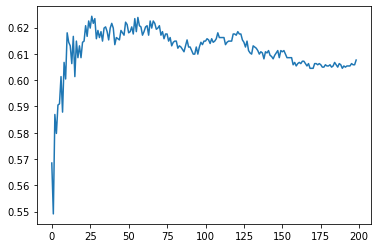

In [25]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.show()

What is the accuracy of the model:

In [26]:
max(scores)

0.6243243243243243

By using the features `tweet_length`, `followers_count`, and `friends_count`, I was able to get up to around 62% accuracy. 

Can we find some different features that perform better?

### Improving the Model

I will add the following features, on top of the current features, to the model to see if I can get a better accuracy:
* The number of links in the tweet.
* The number of words in the tweet. 

Create `links_count` feature:

In [40]:
all_tweets["links_count"] = all_tweets.apply(lambda x: x["text"].count("http"), axis=1)

all_tweets["links_count"].sample(10)

1233     1
10029    1
3243     0
10835    0
6286     0
5351     1
11049    0
6006     1
4126     0
5476     1
Name: links_count, dtype: int64

Create `words_count` feature:

In [41]:
all_tweets["words_count"] = all_tweets.apply(lambda x: len(x["text"].split(" ")), axis=1)

all_tweets["words_count"]

0        26
1        15
2        22
3        24
4        24
         ..
11094    24
11095     9
11096    18
11097    29
11098    13
Name: words_count, Length: 11099, dtype: int64

Now re-build the model with the new features:

In [51]:
data2 = all_tweets[["tweet_length", "followers_count", "friends_count", "links_count", "words_count"]]

scaled_data2 = scale(data2, axis=0)

scaled_data2

array([[ 0.6164054 , -0.02878298, -0.14483305, -0.78415588,  1.15749167],
       [-1.64577622, -0.02886246, -0.16209787, -0.78415588, -0.73053623],
       [ 0.6164054 , -0.02887736, -0.11566596, -0.78415588,  0.47093607],
       ...,
       [ 0.6164054 , -0.02918038, -0.1768776 ,  1.11738358, -0.21561953],
       [ 0.6164054 , -0.02955792, -0.14679496, -0.78415588,  1.67240838],
       [-1.71759151, -0.02208668,  0.0333085 , -0.78415588, -1.07381404]])

In [52]:
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(scaled_data2, labels, test_size = 0.2, random_state = 1)

In [56]:
scores2 = []

for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data2, train_labels2)
    scores2.append(classifier.score(test_data2, test_labels2))

scores2

[0.6833333333333333,
 0.6621621621621622,
 0.7054054054054054,
 0.7130630630630631,
 0.722972972972973,
 0.7247747747747748,
 0.7283783783783784,
 0.7342342342342343,
 0.7373873873873874,
 0.7373873873873874,
 0.7387387387387387,
 0.7387387387387387,
 0.7445945945945946,
 0.7405405405405405,
 0.7441441441441441,
 0.7432432432432432,
 0.740990990990991,
 0.7454954954954955,
 0.740990990990991,
 0.7400900900900901,
 0.7405405405405405,
 0.7378378378378379,
 0.740990990990991,
 0.7364864864864865,
 0.7405405405405405,
 0.7360360360360361,
 0.736936936936937,
 0.7360360360360361,
 0.7391891891891892,
 0.7400900900900901,
 0.7405405405405405,
 0.7378378378378379,
 0.7328828828828828,
 0.7333333333333333,
 0.7306306306306306,
 0.7328828828828828,
 0.7315315315315315,
 0.7301801801801802,
 0.731081081081081,
 0.7297297297297297,
 0.731081081081081,
 0.7324324324324324,
 0.7324324324324324,
 0.7351351351351352,
 0.7342342342342343,
 0.7337837837837838,
 0.7333333333333333,
 0.7351351351351352,

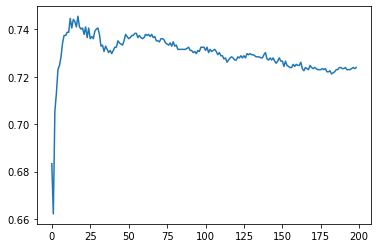

In [57]:
plt.plot(scores2)
plt.show()

In [59]:
max(scores2)

0.7454954954954955

Great! By using the new features `links_count` and `words_count` in addition to `tweet_length`, `followers_count`, and `friends_count`, I was able to improve the accuracy from 62% to around 74%. 


Thus, I will stick with the new model, with the features `tweet_length`, `followers_count`, `friends_count`, `links_count`, and `words_count`.